Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем меньше batch_size, тем чаще придется подгружать данные, что может снизить скорость обучения модели. В то же время, если вычислительные ресурсы ограничены, то и высокий batch_size может снизить скорость обучения ввиду излишней сложности вычислений. Так что, скорее всего, нужно выбрать золотую середину, между большим и маленьким batch_size.

Посмотрим на какую-нибудь картинку:

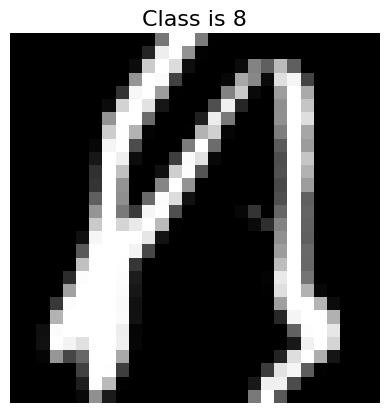

In [5]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





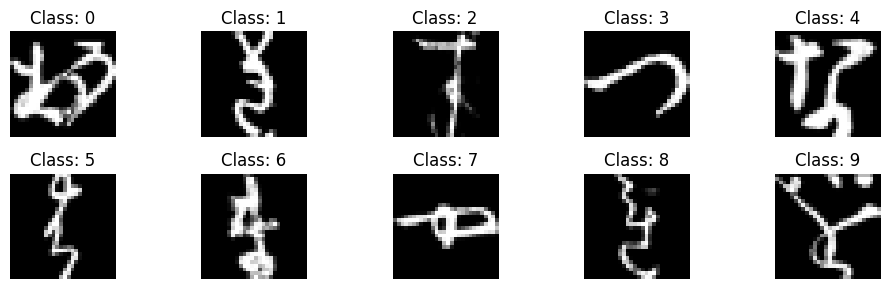

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(10,3))
i = 0
for image, label in trainset:
    if i == 10:
      break
    if label == i:
      ax = axes[i//5, i%5]
      ax.axis('off')
      ax.imshow(image.squeeze(), cmap='gray')
      ax.set_title('Class: {}'.format(label))
      i += 1
plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [27]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [8]:
model = FCNet()
parameters_count = [p.numel() for p in model.parameters()]
print(sum(parameters_count))

235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [10]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [15]:
# Создадим объект модели
model = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [16]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss/len(trainloader))
  print(f'Эпоха {epoch+1}/{n_epochs}, Loss: {loss_history[epoch]:.2f}')

Эпоха 1/10, Loss: 0.91
Эпоха 2/10, Loss: 0.45
Эпоха 3/10, Loss: 0.36
Эпоха 4/10, Loss: 0.31
Эпоха 5/10, Loss: 0.26
Эпоха 6/10, Loss: 0.23
Эпоха 7/10, Loss: 0.20
Эпоха 8/10, Loss: 0.17
Эпоха 9/10, Loss: 0.15
Эпоха 10/10, Loss: 0.13


In [17]:
print(f'{get_accuracy(model, testloader)*100:.2f}%')

87.58%


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [4]:
trainset2 = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset2 = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)
clear_output()
trainloader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True, num_workers=2)
testloader2 = DataLoader(testset2, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
psum = 0
psum_sq = 0
for images, _ in trainloader2:
    psum += images.sum(dim=[0,2,3])
    psum_sq += (images**2).sum([0,2,3])

count = len(trainloader2.dataset) * 28 * 28
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

print(f'{total_mean = }')
print(f'{total_std = }')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


total_mean = tensor([0.1918])
total_std = tensor([0.3483])


In [7]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(total_mean, total_std)
            ])

trainset2.transform = transform_with_norm
testset2.transform = transform_with_norm

In [12]:
model2 = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=3e-4)

In [13]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for inputs, targets in trainloader2:
    optimizer2.zero_grad()
    outputs = model2(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer2.step()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss/len(trainloader2))
  print(f'Эпоха {epoch+1}/{n_epochs}, Loss: {loss_history[epoch]:.2f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Эпоха 1/10, Loss: 0.68
Эпоха 2/10, Loss: 0.30
Эпоха 3/10, Loss: 0.22
Эпоха 4/10, Loss: 0.17
Эпоха 5/10, Loss: 0.14
Эпоха 6/10, Loss: 0.11
Эпоха 7/10, Loss: 0.09
Эпоха 8/10, Loss: 0.08
Эпоха 9/10, Loss: 0.06
Эпоха 10/10, Loss: 0.05


In [14]:
print(f'{get_accuracy(model2, testloader)*100:.2f}%')

84.10%


Как изменилась `accuracy` после нормализации?

Accuracy стало чуть ниже. Однако loss функция показывает результаты в полтора раза меньше... Странно...

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [19]:
class FCNet2(nn.Module):
    def __init__(self, activation):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

In [24]:
import time

In [25]:
n_epochs = 10
loss_history = []
activations = [nn.Sigmoid(), nn.GELU(), nn.Tanh()]
n_epochs = 10
loss_history = []

for activation in activations:
    start = time.time()
    model = FCNet2(activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    loss_history.append([])
    for epoch in range(n_epochs):
        epoch_loss = 0
        for inputs, targets in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        loss_history[-1].append(epoch_loss/len(trainloader))
        print(f'Эпоха {epoch+1}/{n_epochs}, Loss: {loss_history[-1][epoch]:.2f}')
    end = time.time()
    print(f'Accuracy: {get_accuracy(model, testloader)*100:.2f}% Activation: {activation} Time learning: {end-start}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Эпоха 1/10, Loss: 1.79
Эпоха 2/10, Loss: 0.95
Эпоха 3/10, Loss: 0.68
Эпоха 4/10, Loss: 0.56
Эпоха 5/10, Loss: 0.48
Эпоха 6/10, Loss: 0.42
Эпоха 7/10, Loss: 0.38
Эпоха 8/10, Loss: 0.34
Эпоха 9/10, Loss: 0.31
Эпоха 10/10, Loss: 0.29
Accuracy: 81.08% Activation: Sigmoid() Time learning: 117.86287808418274
Эпоха 1/10, Loss: 0.92
Эпоха 2/10, Loss: 0.46
Эпоха 3/10, Loss: 0.36
Эпоха 4/10, Loss: 0.31
Эпоха 5/10, Loss: 0.26
Эпоха 6/10, Loss: 0.23
Эпоха 7/10, Loss: 0.20
Эпоха 8/10, Loss: 0.18
Эпоха 9/10, Loss: 0.16
Эпоха 10/10, Loss: 0.14
Accuracy: 86.55% Activation: GELU(approximate='none') Time learning: 106.17056393623352
Эпоха 1/10, Loss: 0.94
Эпоха 2/10, Loss: 0.51
Эпоха 3/10, Loss: 0.39
Эпоха 4/10, Loss: 0.31
Эпоха 5/10, Loss: 0.26
Эпоха 6/10, Loss: 0.22
Эпоха 7/10, Loss: 0.19
Эпоха 8/10, Loss: 0.16
Эпоха 9/10, Loss: 0.14
Эпоха 10/10, Loss: 0.12
Accuracy: 88.42% Activation: Tanh() Time learning: 105.10975623130798


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Tanh показал наилучшие результаты как по времени обучения, так и по точности предсказаний

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [38]:
n_epochs = 10
loss_history = []
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]

for optimizer in optimizers:
  opt_n = optimizer.__name__
  loss_history.append([])
  start = time.time()
  model = FCNet2(nn.Tanh())
  loss_function = nn.CrossEntropyLoss()
  optimizer = optimizer(model.parameters(), lr=3e-4)
  for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, targets in trainloader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    loss_history[-1].append(epoch_loss/len(trainloader))
    print(f'Эпоха {epoch+1}/{n_epochs}, Loss: {loss_history[-1][epoch]:.2f}')
  end = time.time()
  print(f'Accuracy: {get_accuracy(model, testloader)*100:.2f}% Optimizer: {opt_n} Time learning: {end-start}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Эпоха 1/10, Loss: 0.93
Эпоха 2/10, Loss: 0.51
Эпоха 3/10, Loss: 0.39
Эпоха 4/10, Loss: 0.31
Эпоха 5/10, Loss: 0.26
Эпоха 6/10, Loss: 0.22
Эпоха 7/10, Loss: 0.19
Эпоха 8/10, Loss: 0.16
Эпоха 9/10, Loss: 0.14
Эпоха 10/10, Loss: 0.12
Accuracy: 88.31% Optimizer: Adam Time learning: 104.12766480445862
Эпоха 1/10, Loss: 0.70
Эпоха 2/10, Loss: 0.45
Эпоха 3/10, Loss: 0.35
Эпоха 4/10, Loss: 0.28
Эпоха 5/10, Loss: 0.24
Эпоха 6/10, Loss: 0.20
Эпоха 7/10, Loss: 0.18
Эпоха 8/10, Loss: 0.15
Эпоха 9/10, Loss: 0.13
Эпоха 10/10, Loss: 0.11
Accuracy: 88.51% Optimizer: RMSprop Time learning: 102.40104794502258
Эпоха 1/10, Loss: 1.71
Эпоха 2/10, Loss: 1.32
Эпоха 3/10, Loss: 1.14
Эпоха 4/10, Loss: 1.04
Эпоха 5/10, Loss: 0.97
Эпоха 6/10, Loss: 0.92
Эпоха 7/10, Loss: 0.88
Эпоха 8/10, Loss: 0.85
Эпоха 9/10, Loss: 0.83
Эпоха 10/10, Loss: 0.81
Accuracy: 63.40% Optimizer: Adagrad Time learning: 101.18254709243774


Самым точным и в меру быстрым оказался RMSprop, Adagrad быстрее на секунду, однако намного хуже по точности предсказаний

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [39]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        return torch.max(x, torch.tensor(0))

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [40]:
model = FCNet2(CustomReLU())
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for inputs, targets in trainloader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  loss_history.append(epoch_loss/len(trainloader))
  print(f'Эпоха {epoch+1}/{n_epochs}, Loss: {loss_history[epoch]:.2f}')
print(get_accuracy(model, testloader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Эпоха 1/10, Loss: 0.93
Эпоха 2/10, Loss: 0.44
Эпоха 3/10, Loss: 0.35
Эпоха 4/10, Loss: 0.29
Эпоха 5/10, Loss: 0.25
Эпоха 6/10, Loss: 0.22
Эпоха 7/10, Loss: 0.19
Эпоха 8/10, Loss: 0.17
Эпоха 9/10, Loss: 0.15
Эпоха 10/10, Loss: 0.14
0.8689


Точность получилась идентичная.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Запрос: "самая смешная картинка: 3d render"

![](./rjomba.jpg)

Запрос: "самая грустная картинка: 3d render"

![](./grust.jpg)

Запрос: "маленький муравей наступает на гиганта: pencil drawing"

![](./brainbreak.jpg)

Концептуальненко....